In [1]:
# Loading Libraries
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import log_hyperu as hyperu
import tgr as tgr

import time

In [3]:
# Generating the data sets

torch.manual_seed(12345)

# Structure of the data sets
## Set X_A: Sparse Coefficients with many data points
## Set X_B: Dense Coefficients with many data points
## Set X_C: Sparse Coefficients with few data points
## Set X_D: Dense Coefficients with few data points


### Set X_A
variables = 10
sample = 100
true_coefs = torch.tensor([[0],[0],[5.3],[4.2],[0],[0],[6.9],[0],[0],[0]])
X = torch.randn(sample, variables)
Y = X @ true_coefs + torch.randn(sample, 1) * 0.1
#print(X)

In [218]:
iterations = 1500
starttime = time.time()
trained_model2, coefs, loss_of_optimization = tgr.TripleGammaModel(X, Y, 1, 0.51, 0.001, 2, True, num_epochs=iterations) # Covariates, Targets, Penalty, a, c, kappa, normalization=True
endtime = time.time()
print(f'With {iterations} iterations, TG Regularization took {round(endtime-starttime,4)} seconds. On this system, that is roughly {(endtime-starttime)/iterations} seconds per iteration.')
coefficients = trained_model2.linear.weight.detach().numpy()
#intercept = trained_model2.linear.bias.item()

# For LASSO Imitation: (X, Y, 1, 1, 30, 1, True, num_epochs=2000) # Covariates, Targets, Penalty, a, c, kappa, normalization=True

#print("Coefficients General Function:", coefficients)
#print("Intercept General Function:", intercept)
print(coefficients[0].tolist())
true_coefs_TGR = coefficients[0]

Epoch [100/1500], Loss: 111.72769165039062


KeyboardInterrupt: 

In [133]:
#LASSO
# Define your model
starttime = time.time()
class LinearRegressionLasso(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionLasso, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Define hyperparameters
input_size = 10
output_size = 1
learning_rate = 0.01
num_epochs = 1000
lambda_lasso = 1 # L1 regularization parameter

# Create the model
model = LinearRegressionLasso(input_size, output_size)

# Define loss function (MSE loss with L1 regularization)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, Y)

    # Total loss with L1 regularization
    l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())

    loss = loss + lambda_lasso * l1_norm
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

endtime = time.time()
print(f'With {num_epochs} iterations, Regular LASSO Regularization took {round(endtime-starttime,4)} seconds. On this system, that is roughly {(endtime-starttime)/num_epochs} seconds per iteration.')

# After training, you can access the learned coefficients
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.data.tolist()}')
        coefs_LASSO = param.data.tolist()


Epoch [100/1000], Loss: 10.6036
Epoch [200/1000], Loss: 7.0338
Epoch [300/1000], Loss: 6.6343
Epoch [400/1000], Loss: 6.5833
Epoch [500/1000], Loss: 6.5743
Epoch [600/1000], Loss: 6.5747
Epoch [700/1000], Loss: 6.5778
Epoch [800/1000], Loss: 6.5804
Epoch [900/1000], Loss: 6.5821
Epoch [1000/1000], Loss: 6.5785
With 1000 iterations, Regular LASSO Regularization took 1.3717 seconds. On this system, that is roughly 0.0013716657161712646 seconds per iteration.
linear.weight: [[-0.08131898939609528, 0.11880242824554443, 5.130025863647461, 4.099651336669922, 0.0024799692910164595, -0.008265404962003231, 6.229494094848633, -0.03251353278756142, 0.006142516154795885, -0.11067549884319305]]


In [148]:
def CopmuteRMSE(Y, X, coefficients, method):
    # Variable Type Check
    if not all(isinstance(t, torch.Tensor) for t in [Y, X, coefficients]):
        raise ValueError("Not all inputs are PyTorch tensors!")
    
    Y_hat = X @ coefficients
    Y = torch.squeeze(Y)
    mse = torch.sum((Y - Y_hat)**2)
    rmse = torch.sqrt(mse)
    print(method)
    #print(Y_hat)
    #print(Y)
    print(rmse)

In [182]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
ols = model.coef_.tolist()[0] 

In [186]:
print("True COEFS", torch.squeeze(true_coefs).T.tolist())
print("TGR:",torch.tensor(true_coefs_TGR).tolist())
print("LASSO:",torch.squeeze(torch.tensor(coefs_LASSO)).tolist())
print("OLS:", ols)
print("\n")
CopmuteRMSE(Y,X,torch.tensor(true_coefs_TGR), "TGR")
CopmuteRMSE(Y,X,torch.squeeze(torch.tensor(coefs_LASSO)), "LASSO")
CopmuteRMSE(Y,X,torch.squeeze(torch.tensor(ols)), "OLS")

True COEFS [0.0, 0.0, 5.300000190734863, 4.199999809265137, 0.0, 0.0, 6.900000095367432, 0.0, 0.0, 0.0]
TGR: [0.005852716509252787, -0.003165281843394041, 5.298001289367676, 4.181629180908203, -0.006983057130128145, 2.2076303139328957e-05, 6.898454666137695, -0.008982997387647629, -0.00298516359180212, -0.00657022837549448]
LASSO: [-0.08131898939609528, 0.11880242824554443, 5.130025863647461, 4.099651336669922, 0.0024799692910164595, -0.008265404962003231, 6.229494094848633, -0.03251353278756142, 0.006142516154795885, -0.11067549884319305]
OLS: [-0.011616242118179798, 0.005331128835678101, 5.29803991317749, 4.181795120239258, -0.013096123933792114, 0.003976382315158844, 6.89629602432251, -0.014410754665732384, -0.0016365605406463146, -0.008706651628017426]


TGR
tensor(0.9780)
LASSO
tensor(5.8565)
OLS
tensor(0.9644)


In [21]:
##### PREDICTION SCRIPT

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt
import tgr as tgr
import log_hyperu as hyperu

# Set random seed for reproducibility
torch.manual_seed(123) # 42
np.random.seed(123) # 42

# Step 1: Generate synthetic data
n_samples = 100
n_features = 25
n_nonzero = 3
n_epochs = 500
lambda_grid = [0.01*i for i in range(0,100,1)]

output_list = list() # Contains Tuples with (METHOD, LAMBDA, LOSS, COEFS)

# True coefficients with sparsity (many coefficients are zero)
true_coefficients = torch.zeros(n_features)
true_coefficients[:n_nonzero] = torch.randn(n_nonzero)

# Generate features
X = torch.randn(n_samples, n_features)

# Generate targets with noise
noise = torch.randn(n_samples) * 0.5
y = X @ true_coefficients + noise

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2.5: Find optimal lambda for lasso
#grid_search.fit(X_train, y_train)
#optimal_lambda = grid_search.best_params_['alpha']
#print(f"Optimal lambda for LASSO: {optimal_lambda}")

# Step 3: Implement OLS and Lasso regression using PyTorch

class LinearRegression(nn.Module):
    def __init__(self, n_features):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(n_features, 1, bias=False)
        
    def forward(self, x):
        return self.linear(x)

def train_model(model, X_train, y_train, lr=0.01, n_epochs=1000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
    return model

# Train OLS model
ols_model = LinearRegression(n_features)
ols_model = train_model(ols_model, X_train, y_train)
ols_loss = ComputeValidationLoss(ols_model, X_test, y_test)

output_list.append(("OLS","0",ols_loss,ols_model.linear.weight.detach().numpy().flatten()))
# Train Lasso model
best_loss = 10000000000 # Hard Gecoded!
for lasso_reg_strength in lambda_grid:
    lasso_model = LinearRegression(n_features)
    def lasso_loss(output, target, model, lasso_reg_strength):
        mse_loss = nn.MSELoss()(output, target)
        lasso_loss = lasso_reg_strength * torch.norm(model.linear.weight, 1)
        return mse_loss + lasso_loss

    optimizer = torch.optim.SGD(lasso_model.parameters(), lr=0.01)

    for epoch in range(n_epochs):
        lasso_model.train()
        
        optimizer.zero_grad()
        outputs = lasso_model(X_train).squeeze()
        loss = lasso_loss(outputs, y_train, lasso_model, lasso_reg_strength)
        loss.backward()
        optimizer.step()
    
    val_loss = ComputeValidationLoss(lasso_model, X_test, y_test)
    
    if val_loss < best_loss:
        best_lamda = lasso_reg_strength
        best_loss = val_loss
        best_model = lasso_model

output_list.append(("LASSO",best_lamda,best_loss,best_model.linear.weight.detach().numpy().flatten()))

# Train TGR Model
best_loss = 10000000000 # Hard Gecoded!
for tgr_reg_strength in lambda_grid:
    tgr_model1_LASSO = LinearRegression(n_features)
    def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
        mse_loss = nn.MSELoss()(output, target)
        phi = torch.tensor((2*c)/((kappa**2)*a))
        tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

        return mse_loss + tgr_loss
    
    optimizer = torch.optim.SGD(tgr_model1_LASSO.parameters(), lr=0.01)

    for epoch in range(n_epochs):
        tgr_model1_LASSO.train()
        
        optimizer.zero_grad()
        outputs = tgr_model1_LASSO(X_train).squeeze()
        loss = tgr_loss(outputs, y_train, tgr_model1_LASSO, 0.25, 1, 30, 1)
        loss.backward()
        nn.utils.clip_grad_norm_(tgr_model1_LASSO.parameters(), 1.0)
        optimizer.step()
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item()}')

    val_loss = ComputeValidationLoss(tgr_model1_LASSO, X_test, y_test)

    if val_loss < best_loss:
        best_lamda = tgr_reg_strength
        best_loss = val_loss
        best_model = tgr_model1_LASSO
    
output_list.append(("TGR-LASSO",best_lamda,best_loss,best_model.linear.weight.detach().numpy().flatten()))

# Arctan Model
best_loss = 10000000000 # Hard Gecoded!
for arctan_reg_strength in lambda_grid:
    arctan_model = LinearRegression(n_features)
    def arctan_loss(output, target, model, arctan_reg_strength):
        mse_loss = nn.MSELoss()(output, target)
        arctan_loss = arctan_reg_strength*torch.sum((2/np.pi) * torch.arctan(torch.abs(model.linear.weight)))
        return mse_loss + arctan_loss
    
    for epoch in range(n_epochs):
        arctan_model.train()
        
        optimizer.zero_grad()
        outputs = arctan_model(X_train).squeeze()
        loss = arctan_loss(outputs, y_train, arctan_model, arctan_reg_strength)
        loss.backward()
        nn.utils.clip_grad_norm_(arctan_model.parameters(), 1.0)
        optimizer.step()
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item()}')
        
    val_loss = ComputeValidationLoss(arctan_model, X_test, y_test)

    if val_loss < best_loss:
        best_lamda = arctan_reg_strength
        best_loss = val_loss
        best_model = arctan_model
    
output_list.append(("Arctan",best_lamda,best_loss,best_model.linear.weight.detach().numpy().flatten()))

        
## TGR - Special
tgr_model2_Special = LinearRegression(n_features)
best_loss = 10000000000 # Hard Gecoded!
for tgr_reg_strength in lambda_grid:
    def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
        mse_loss = nn.MSELoss()(output, target)
        phi = torch.tensor((2*c)/((kappa**2)*a))
        tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

        return mse_loss + tgr_loss

    optimizer = torch.optim.SGD(tgr_model2_Special.parameters(), lr=0.01)

    for epoch in range(n_epochs):
        tgr_model2_Special.train()
        
        optimizer.zero_grad()
        outputs = tgr_model2_Special(X_train).squeeze()
        loss = tgr_loss(outputs, y_train, tgr_model2_Special, tgr_reg_strength, 0.75, 20, 2)
        loss.backward()
        nn.utils.clip_grad_norm_(tgr_model2_Special.parameters(), 1.0)
        optimizer.step()
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item()}')

    if val_loss < best_loss:
        best_lamda = tgr_reg_strength
        best_loss = val_loss
        best_model = tgr_model2_Special

output_list.append(("TGR - Special",best_lamda,best_loss,best_model.linear.weight.detach().numpy().flatten()))


print(f"OLS RMSE: {ols_rmse}")
print(f"Lasso RMSE: {lasso_rmse}")
print(f"TGR Lasso RMSE: {tgr_LASSO_rmse}")
print(f"TGR RMSE: {tgr_rmse}")
print(f"Arctan Loss: {arctan_rmse}")

# Step 5: Plot the true and estimated coefficients

# Get the estimated coefficients
#ols_coefficients = ols_model.linear.weight.detach().numpy().flatten()
#lasso_coefficients = lasso_model.linear.weight.detach().numpy().flatten()
#tgr_coefficients_LASSO = tgr_model1_LASSO.linear.weight.detach().numpy().flatten()
#tgr_coefficients_Special = tgr_model2_Special.linear.weight.detach().numpy().flatten()
#arctan_coefficients = arctan_model.linear.weight.detach().numpy().flatten()
#true_coefficients_np = true_coefficients.numpy()

# Plotting
#fig = plt.figure(figsize=(12, 6))
#ax = fig.add_subplot(1, 1, 1)
#plt.plot(true_coefficients_np, label='True Coefficients', marker='o')
#plt.plot(ols_coefficients, label='OLS Estimated', marker='x')
#plt.plot(lasso_coefficients, label='LASSO Estimated', marker='.')
#plt.plot(tgr_coefficients_LASSO, label='TGR Estimated - LASSO Replica', marker='.')
#plt.plot(tgr_coefficients_Special, label='TGR Estimated - Example', marker='.')
#plt.plot(arctan_coefficients, label='Arctan Estimated', marker='.')
#plt.xlabel('Feature Index')
#plt.ylabel('Coefficient Value')
#plt.title('True vs Estimated Coefficients')

#major_ticks = np.arange(0, 10, 1)
#ax.set_xticks(major_ticks)

#plt.legend()
#plt.grid(True)
#plt.show()


Epoch [100/500], Loss: 0.3655189573764801
Epoch [200/500], Loss: 0.35940754413604736
Epoch [300/500], Loss: 0.3588652014732361
Epoch [400/500], Loss: 0.3591199815273285
Epoch [500/500], Loss: 0.36044442653656006
Epoch [100/500], Loss: 0.35954350233078003
Epoch [200/500], Loss: 0.36068010330200195
Epoch [300/500], Loss: 0.35909420251846313
Epoch [400/500], Loss: 0.3589637875556946
Epoch [500/500], Loss: 0.3584367036819458
Epoch [100/500], Loss: 0.3587866425514221
Epoch [200/500], Loss: 0.35888543725013733
Epoch [300/500], Loss: 0.3582509160041809
Epoch [400/500], Loss: 0.3582497239112854
Epoch [500/500], Loss: 0.3593846559524536
Epoch [100/500], Loss: 0.359093576669693
Epoch [200/500], Loss: 0.36009037494659424
Epoch [300/500], Loss: 0.3578297793865204
Epoch [400/500], Loss: 0.3591449558734894
Epoch [500/500], Loss: 0.35863155126571655
Epoch [100/500], Loss: 0.3580813705921173
Epoch [200/500], Loss: 0.35943007469177246
Epoch [300/500], Loss: 0.3585241436958313
Epoch [400/500], Loss: 0.3

In [314]:
### Absolut Deviation Plot

# Set random seed for reproducibility
torch.manual_seed(123) # 42
np.random.seed(123) # 42

# Step 1: Generate synthetic data
n_samples = 100
n_features = 10
n_nonzero = 3
runs = 100

ols_dev_list = list()
lasso_dev_list = list()
tgr_dev_list = list()

for run in range(runs):
    # True coefficients with sparsity (many coefficients are zero)
    true_coefficients = torch.zeros(n_features)
    true_coefficients[:n_nonzero] = torch.randn(n_nonzero)

    # Generate features
    X = torch.randn(n_samples, n_features)

    # Generate targets with noise
    noise = torch.randn(n_samples) * 0.5
    y = X @ true_coefficients + noise

    # Step 2: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 3: Implement OLS and Lasso regression using PyTorch
    class LinearRegression(nn.Module):
        def __init__(self, n_features):
            super(LinearRegression, self).__init__()
            self.linear = nn.Linear(n_features, 1, bias=False)
            
        def forward(self, x):
            return self.linear(x)

    def train_model(model, X_train, y_train, lr=0.01, n_epochs=1000):
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
        for epoch in range(n_epochs):
            model.train()
            
            optimizer.zero_grad()
            outputs = model(X_train).squeeze()
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            
        return model

    # Train OLS model
    ols_model = LinearRegression(n_features)
    ols_model = train_model(ols_model, X_train, y_train)

    # Train Lasso model
    lasso_model = LinearRegression(n_features)
    lasso_reg_strength = 0.25 # Regularization strength

    def lasso_loss(output, target, model, lasso_reg_strength):
        mse_loss = nn.MSELoss()(output, target)
        lasso_loss = lasso_reg_strength * torch.norm(model.linear.weight, 1)
        return mse_loss + lasso_loss

    optimizer = torch.optim.SGD(lasso_model.parameters(), lr=0.01)
    n_epochs = 1000

    for epoch in range(n_epochs):
        lasso_model.train()
        
        optimizer.zero_grad()
        outputs = lasso_model(X_train).squeeze()
        loss = lasso_loss(outputs, y_train, lasso_model, lasso_reg_strength)
        loss.backward()
        optimizer.step()

    # Train TGR Model
    tgr_model2_Special = LinearRegression(n_features)

    def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
        mse_loss = nn.MSELoss()(output, target)
        phi = torch.tensor((2*c)/((kappa**2)*a))
        tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

        return mse_loss + tgr_loss

    ## TGR - Special
    optimizer = torch.optim.SGD(tgr_model2_Special.parameters(), lr=0.01)
    n_epochs = 1000

    for epoch in range(n_epochs):
        tgr_model2_Special.train()
        
        optimizer.zero_grad()
        outputs = tgr_model2_Special(X_train).squeeze()
        loss = tgr_loss(outputs, y_train, tgr_model2_Special, 0.05, 0.75, 20, 2)
        loss.backward()
        nn.utils.clip_grad_norm_(tgr_model2_Special.parameters(), 1.0)
        optimizer.step()

    # Step 5: Plot the true and estimated coefficients

    # Get the estimated coefficients
    ols_coefficients = ols_model.linear.weight.detach().numpy().flatten()
    lasso_coefficients = lasso_model.linear.weight.detach().numpy().flatten()
    tgr_coefficients_Special = tgr_model2_Special.linear.weight.detach().numpy().flatten()
    true_coefficients_np = true_coefficients.numpy()

    # Get absolute deviation
    ols_dev_list.append(sum(abs(ols_coefficients-true_coefficients_np)))
    lasso_dev_list.append(sum(abs(lasso_coefficients-true_coefficients_np)))
    tgr_dev_list.append(sum(abs(tgr_coefficients_Special - true_coefficients_np)))
    
    print(f'Finished run {run} of {runs}')


Finished run 0 of 100
Finished run 1 of 100
Finished run 2 of 100
Finished run 3 of 100
Finished run 4 of 100
Finished run 5 of 100
Finished run 6 of 100
Finished run 7 of 100
Finished run 8 of 100
Finished run 9 of 100
Finished run 10 of 100
Finished run 11 of 100
Finished run 12 of 100
Finished run 13 of 100
Finished run 14 of 100
Finished run 15 of 100
Finished run 16 of 100
Finished run 17 of 100
Finished run 18 of 100
Finished run 19 of 100
Finished run 20 of 100
Finished run 21 of 100
Finished run 22 of 100
Finished run 23 of 100
Finished run 24 of 100
Finished run 25 of 100
Finished run 26 of 100
Finished run 27 of 100
Finished run 28 of 100
Finished run 29 of 100
Finished run 30 of 100
Finished run 31 of 100
Finished run 32 of 100
Finished run 33 of 100
Finished run 34 of 100
Finished run 35 of 100
Finished run 36 of 100
Finished run 37 of 100
Finished run 38 of 100
Finished run 39 of 100
Finished run 40 of 100
Finished run 41 of 100
Finished run 42 of 100
Finished run 43 of 10

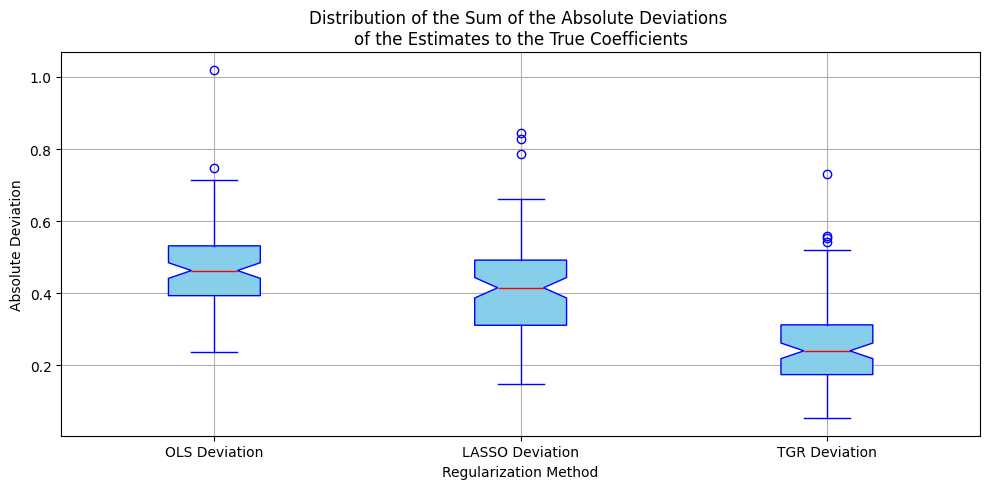

In [334]:
#print(ols_dev_list)
#print(lasso_dev_list)
#print(tgr_dev_list)

# Combine data into a list
data = [ols_dev_list, lasso_dev_list, tgr_dev_list]

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Plot box plots
ax.boxplot(data, patch_artist=True, notch=True,
            boxprops=dict(facecolor='skyblue', color='blue'),
            capprops=dict(color='blue'),
            whiskerprops=dict(color='blue'),
            flierprops=dict(color='blue', markeredgecolor='blue'),
            medianprops=dict(color='red'))
plt.title('Distribution of the Sum of the Absolute Deviations \nof the Estimates to the True Coefficients')
ax.set_xlabel('Regularization Method')
ax.set_ylabel('Absolute Deviation')
ax.set_xticklabels(['OLS Deviation', 'LASSO Deviation', 'TGR Deviation'])
major_ticks = np.arange(1, 4, 1)
ax.set_xticks(major_ticks)

# Adjust layout
plt.tight_layout()
plt.grid(True)

# Show the plot
plt.show()
